In [187]:
import cv2
import numpy as np
import json
from matplotlib import pyplot as plt

# Define Image Data Structure

In [188]:
class ImageData:
    def __init__(self, img, actual_polygons):
        self.img = img
        self.actual_polygons = actual_polygons
        self.watershed_polygons = []
        self.improved_watershed_polygons = []

    def add_watershed_polygons(self, polygon):
        self.watershed_polygons.append(polygon)

    def add_improved_watershed_polygons(self, polygon):
        self.improved_watershed_polygons.append(polygon)

    def segment(self, polygons):
        mask = np.zeros(self.img.shape[:2], np.uint8)
        cv2.fillPoly(mask, polygons, 255)
        return cv2.bitwise_or(self.img, self.img, mask=mask)

    def show(self):
        plt.imshow(self.img)
        plt.show()

    def show_segment(self, polygons):
        segment = self.segment(polygons)
        plt.imshow(segment)
        plt.show()

    def show_segment_comparison(self, polygons1, polygons2, polygons3):
        segment1 = self.segment(polygons1)
        segment2 = self.segment(polygons2)
        segment3 = self.segment(polygons3)
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(segment1)
        ax[1].imshow(segment2)
        ax[2].imshow(segment3)
        plt.show()

# Load the Datasets

In [189]:
# Initialize empty list of image data
image_datas = []

# Load labels from JSON
labels = json.load(open('datasets/labels.json'))

# Load image data
for image_datas_raw in labels:
    filename = image_datas_raw['data']['image']
    img = cv2.imread('datasets/' + filename, cv2.IMREAD_COLOR)
    polygons = []
    for annotation in image_datas_raw['annotations']:
        for result in annotation['result']:
            polygons.append(
                np.array(np.matmul(result['value']['points'], [
                         [img.shape[1] / 100, 0], [0, img.shape[0] / 100]]), np.int32)
            )
    image_datas.append(ImageData(img, polygons))

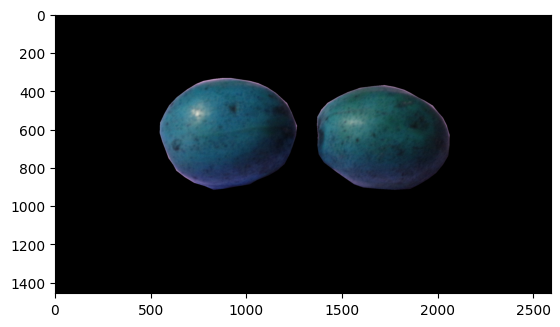

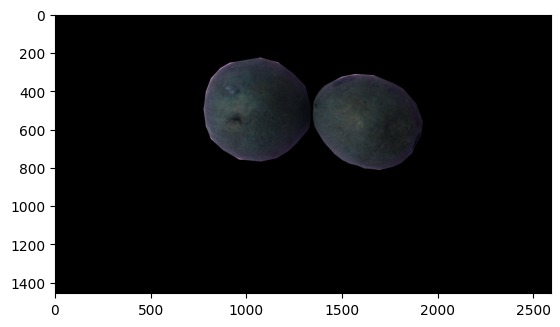

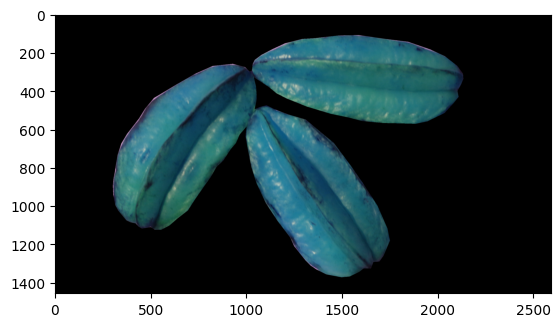

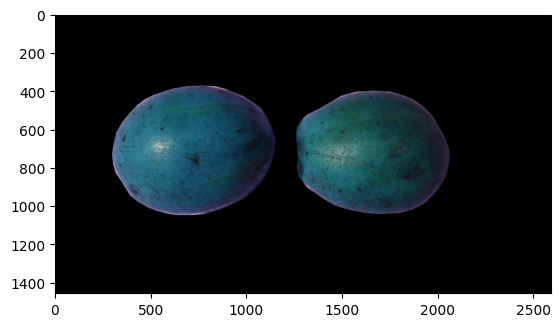

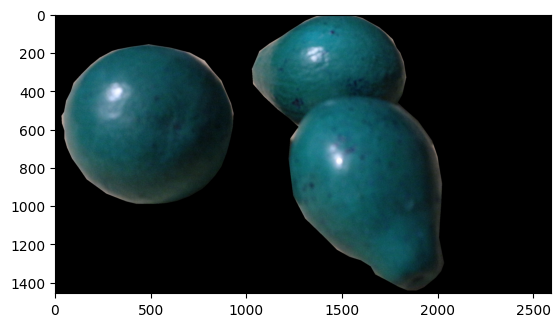

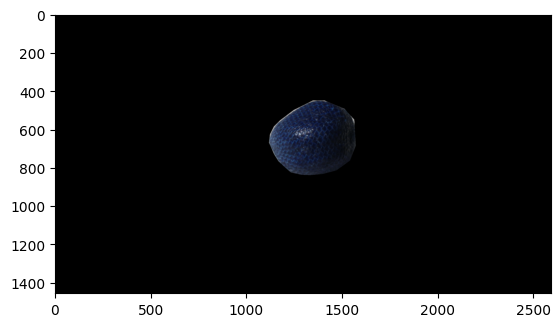

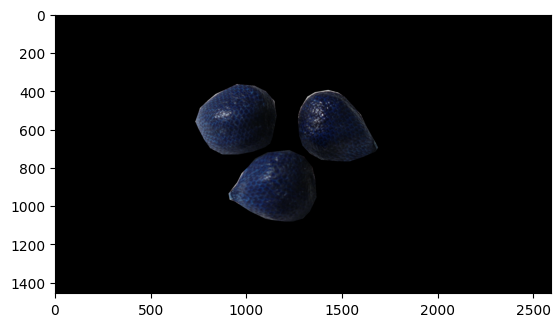

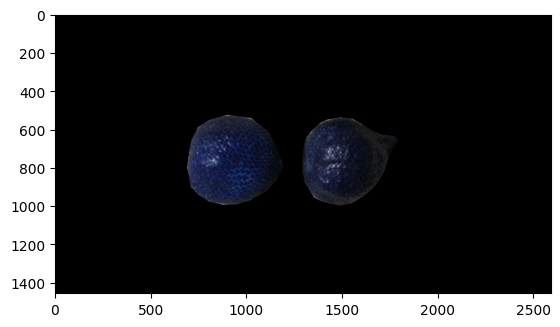

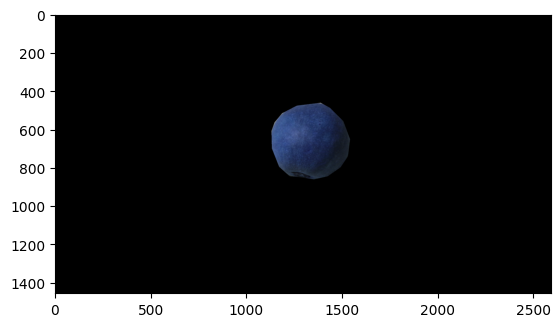

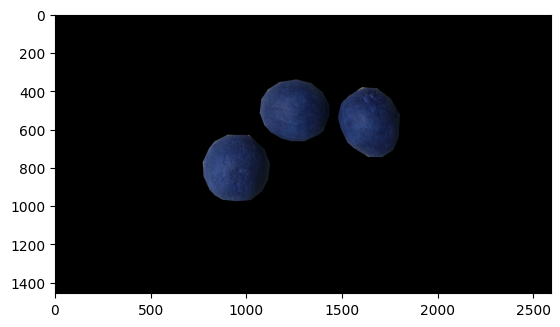

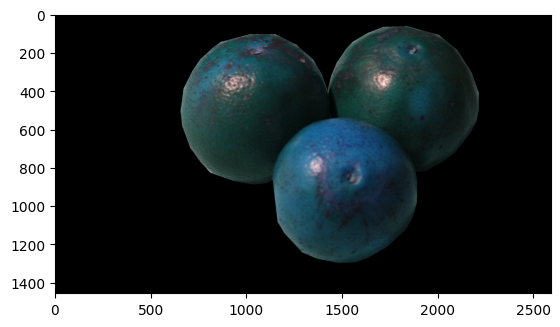

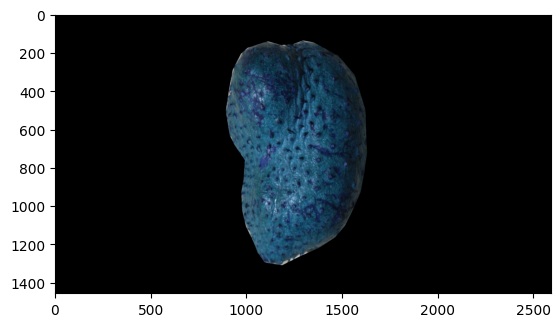

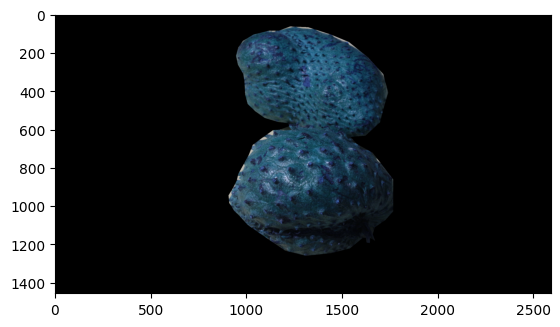

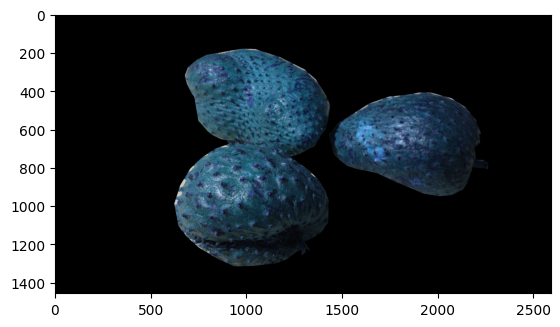

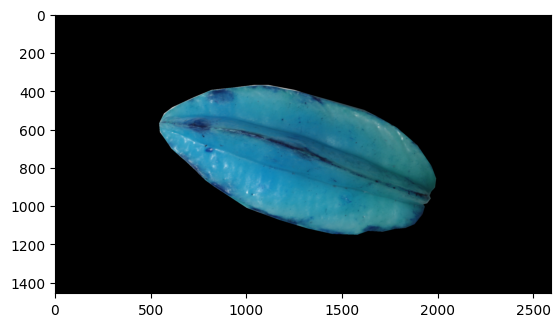

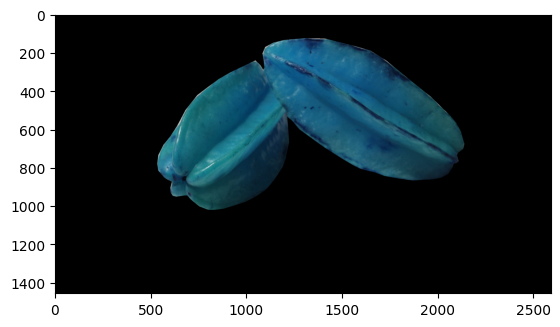

In [190]:
for image_data in image_datas:
    image_data.show_segment(image_data.actual_polygons)

# Watershed Segmentation

In [216]:
image_data.watershed_polygons = []
for image_data in image_datas:
    image = image_data.img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Menggunakan threshold untuk menentukan batas objek
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Menerapkan transformasi morfologi untuk membersihkan gambar
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Mengaplikasikan operasi sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Menemukan sure foreground area menggunakan transformasi distansi
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Mencari unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Membuat label untuk komponen yang terhubung
    ret, markers = cv2.connectedComponents(sure_fg)

    # Menandai area tidak pasti dengan 0
    markers[unknown == 255] = -1

    # Menerapkan algoritma watershed
    markers = cv2.watershed(img, markers)

    # markers1 = markers.astype(np.uint8)
    # ret, m2 = cv2.threshold(
    #     markers1, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Find contours of the markers
    contours, _ = cv2.findContours(
        sure_fg, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Store polygons in a list
    for cnt in contours:
        image_data.add_watershed_polygons(np.squeeze(cnt))

# Visualize the Results

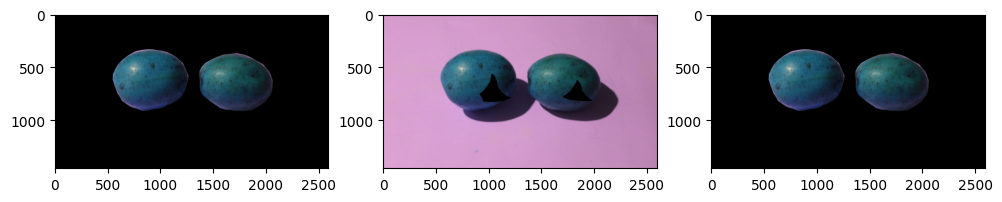

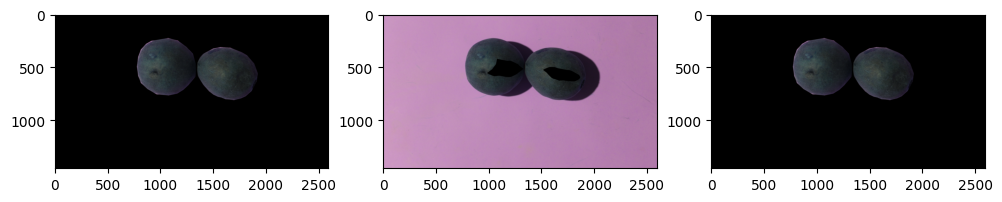

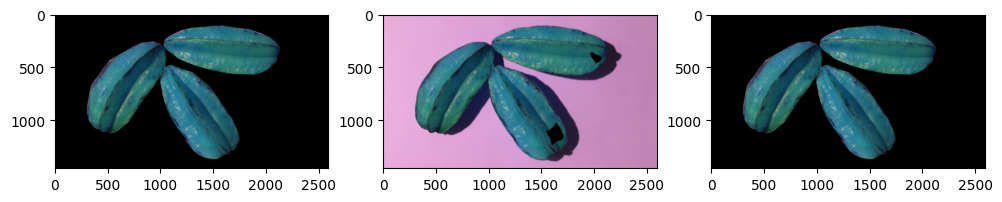

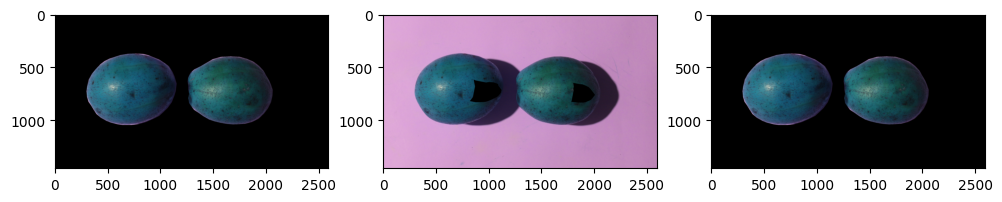

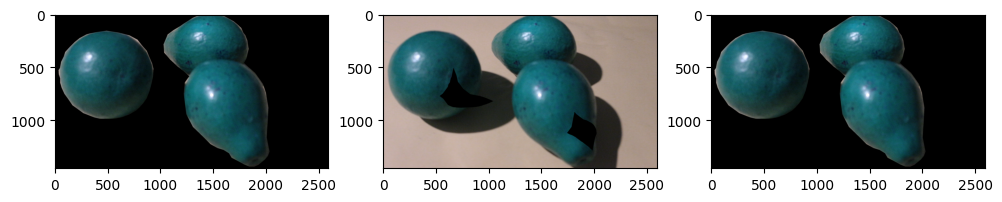

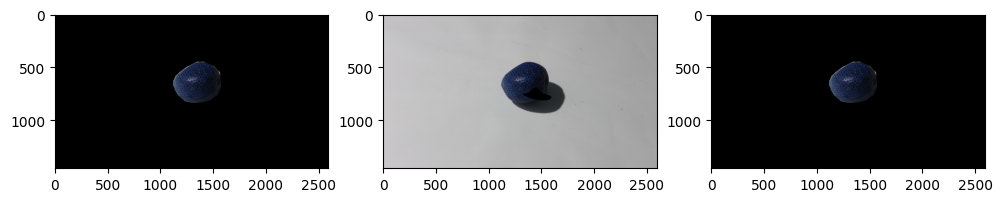

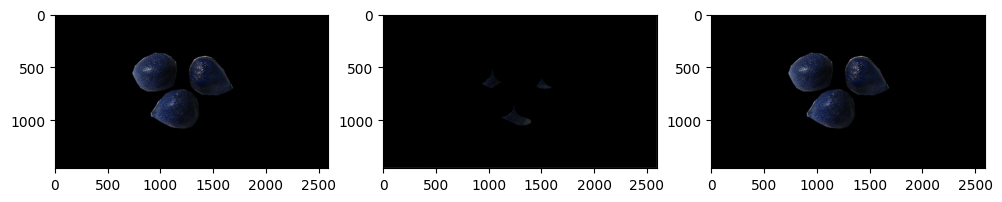

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'fillPoly'
> Overload resolution failed:
>  - Can't parse 'pts'. Sequence item with index 6 has a wrong type
>  - Can't parse 'pts'. Sequence item with index 6 has a wrong type


In [217]:
for image_data in image_datas:
    image_data.show_segment_comparison(
        image_data.actual_polygons, image_data.watershed_polygons, image_data.actual_polygons)